# SETUP


## 1. Installs & Imports


In [ ]:
# Standard libraries
import os
import json
import glob
import shutil
import tempfile
import random
import warnings
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Third-party libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import albumentations as A
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.nn.functional as F
from skimage import filters
from skimage.measure import label as label_fn, regionprops
from skimage import morphology
from sklearn.model_selection import train_test_split
from copy import deepcopy
from tqdm.notebook import tqdm

# MONAI related imports
from monai.config import print_config
from monai.networks.nets import UNet, SwinUNETR, BasicUNetPlusPlus
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.transforms import (
    AsDiscrete, AsDiscreted, EnsureChannelFirstd, Compose, CropForegroundd,
    LoadImaged, Orientationd, RandCropByPosNegLabeld, SaveImaged, ScaleIntensityRanged,
    Spacingd, Invertd, ResizeWithPadOrCropd, Resized, MapTransform, ScaleIntensityd,
    LabelToContourd, ForegroundMaskd, HistogramNormalized, RandFlipd, RandGridDistortiond,
    RandHistogramShiftd, RandRotated
)
from monai.handlers.utils import from_engine
from monai.utils.type_conversion import convert_to_numpy

# PyTorch Lightning related imports
import lightning.pytorch as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch import seed_everything

from natsort import natsorted, ns
from PIL import Image
from numpy import einsum
from torch.utils.data import default_collate
import psutil
from typing import List
import monai

# Import modules
from breast_segmentation.config.settings import config
from breast_segmentation.utils.seed import set_deterministic_mode, seed_worker, reseed
from breast_segmentation.data.dataset import (
    get_image_label_files, create_data_dicts, split_data, create_dataloaders, get_dataset_base_path
)
from breast_segmentation.data import custom_collate_no_patches
from breast_segmentation.transforms.compose import Preprocess
from breast_segmentation.models.lightning_module import BreastSegmentationModel
from breast_segmentation.models.architectures import get_model
from breast_segmentation.metrics.losses import get_loss_function, CrossEntropy2d, compute_class_weight, AsymmetricUnifiedFocalLoss
from breast_segmentation.utils.visualization import (
    plot_batch_predictions, plot_training_history
)
from breast_segmentation.utils.postprocessing import (
    remove_far_masses_based_on_largest_mass
)

from boundaryloss.dataloader import dist_map_transform

from breast_segmentation.data.private_dataset import (
    PATIENT_INFO, get_filenames, get_train_val_test_dicts, PATIENTS_TO_EXCLUDE
)


# Import additional loss functions used in original
from monai.losses import DiceLoss, DiceCELoss

# Set precision for matmul operations and print MONAI config
torch.set_float32_matmul_precision('medium')
print_config()


c:\Users\pabli\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


MONAI version: 1.6.dev2535
Numpy version: 2.0.2
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8e677816bfd1fb2ec541d7f951db4caaf210b150
MONAI __file__: c:\Users\<username>\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 11.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED o

## 2. Environment Setup


In [2]:
patient_ids = list(PATIENT_INFO.keys())[:3]

# Apply exclusions (exactly as in reference notebook)
print(f"Initial patients from PATIENT_INFO: {len(patient_ids)}")
print(f"Patients to exclude: {PATIENTS_TO_EXCLUDE}")
patient_ids = [pid for pid in patient_ids if pid not in PATIENTS_TO_EXCLUDE]
print(f"Patients after exclusion: {len(patient_ids)}")

# Data split using original train_test_split
SEED = 200 
dataset_base_path = "Dataset-arrays-4-FINAL"
x_train_val, x_test = train_test_split(patient_ids, test_size=0.2, random_state=SEED)
x_train, x_val = train_test_split(x_train_val, test_size=0.25, random_state=SEED)


print("Creating data dictionaries with filtering logic...")
train_dicts, val_dicts, test_dicts = get_train_val_test_dicts(dataset_base_path, x_train, x_val, x_test)

print(f"\ndata:")
print(f"  Training samples: {len(train_dicts)}")
print(f"  Validation samples: {len(val_dicts)}")
print(f"  Test samples: {len(test_dicts)}")


Initial patients from PATIENT_INFO: 3
Patients to exclude: ['CMG0948', 'IM0544(1,5)B-merged', 'D2MP8(VR)', 'VC0285(1,5)B-merged']
Patients after exclusion: 3
Creating data dictionaries with filtering logic...

data:
  Training samples: 126
  Validation samples: 228
  Test samples: 212


In [3]:
# Configuration
batch_size = 24
num_workers = os.cpu_count()
checkpoints_dir = config.CHECKPOINTS_DIR
get_boundaryloss = False

# Ensure checkpoints directory exists
os.makedirs(checkpoints_dir, exist_ok=True)

# Set random seed for reproducibility
g = set_deterministic_mode(config.SEED)

print(f"Batch size: {batch_size}")
print(f"Number of workers: {num_workers}")
print(f"Checkpoints directory: {checkpoints_dir}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name()}")


Seed set to 200


Using random seed 200...
Batch size: 24
Number of workers: 24
Checkpoints directory: checkpoints
CUDA available: True
Device: NVIDIA GeForce RTX 3060


## 4. Private Dataset Preprocessing Pipeline


In [4]:
# Define subtracted images path prefixes (CRITICAL: Private dataset DOES use subtracted images)
sub_third_images_path_prefixes = ("Dataset-arrays-4-FINAL", "Dataset-arrays-FINAL")

# Create transforms for statistics calculation (EXACT as reference notebook)
statistics_transforms_private = Compose([
    LoadImaged(
        keys=["image", "label"], 
        image_only=False, 
        reader=monai.data.NumpyReader()  # EXACT: Use NumpyReader like reference
    ),
    EnsureChannelFirstd(keys=["image", "label"]),
    Preprocess(
        keys=None, 
        mode='statistics',  
        dataset="private", 
        subtracted_images_path_prefixes=sub_third_images_path_prefixes, 
        get_patches=False
    )
])

print("Statistics transforms created for private dataset (EXACT as reference)")


Statistics transforms created for private dataset (EXACT as reference)


In [ ]:
# Create dataset for statistics calculation
statistics_ds_private = CacheDataset(
    data=train_dicts, 
    transform=statistics_transforms_private,
    num_workers=num_workers
)

statistics_loader_private = DataLoader(
    statistics_ds_private, 
    batch_size=batch_size, 
    worker_init_fn=seed_worker,
    generator=g, 
    shuffle=False, 
    drop_last=False,
    collate_fn=custom_collate_no_patches  # EXACT: Use custom collate as reference
)

print("Statistics dataset and loader created (with custom collate as reference)")


Loading dataset: 100%|██████████| 126/126 [00:04<00:00, 28.13it/s]

Statistics dataset and loader created (with custom collate as reference)


In [6]:
# Calculate mean and std for normalization
def get_mean_std_dataloader(dataloader, masked=False):
    """Calculate mean and std from dataloader."""
    sum_of_images = 0.0
    sum_of_squares = 0.0
    num_pixels = 0

    for batch in tqdm(dataloader):
        if batch is not None:
            image = batch["image"]
      
            if masked:
                mask = image > 0.0
                image = image[mask]
      
            sum_of_images += image.sum()
            sum_of_squares += (image ** 2).sum()
            num_pixels += image.numel()
        else:
            print("batch is None")
    
    mean = sum_of_images / num_pixels
    std_dev = (sum_of_squares / num_pixels - mean ** 2) ** 0.5

    print(f'Mean: {mean}, Standard Deviation: {std_dev}')
    return mean.item(), std_dev.item()

mean_private, std_private = get_mean_std_dataloader(statistics_loader_private)
print(f"Calculated - Mean: {mean_private}, Standard Deviation: {std_private}")

  0%|          | 0/6 [00:00<?, ?it/s]

Mean: 19.024364471435547, Standard Deviation: 173.03067016601562
Calculated - Mean: 19.024364471435547, Standard Deviation: 173.03067016601562


In [7]:
# Create final transforms with calculated statistics
test_transforms_private = Compose([
    LoadImaged(
        keys=["image", "label"], 
        image_only=False, 
        reader=monai.data.PILReader(converter=lambda image: image.convert("L"))
    ),
    EnsureChannelFirstd(keys=["image", "label"]),
    monai.transforms.Rotate90d(keys=["image", "label"]),
    Preprocess(
        keys=None, 
        mode='test',  
        dataset="private", 
        subtracted_images_path_prefixes=sub_third_images_path_prefixes, 
        subtrahend=mean_private, 
        divisor=std_private, 
        get_patches=False,
        get_boundaryloss=get_boundaryloss
    )
])

train_transforms_private = Compose([
    LoadImaged(
        keys=["image", "label"], 
        image_only=False, 
        reader=monai.data.PILReader(converter=lambda image: image.convert("L"))
    ),
    EnsureChannelFirstd(keys=["image", "label"]),
    monai.transforms.Rotate90d(keys=["image", "label"]),
    Preprocess(
        keys=None, 
        mode='train', 
        dataset="private", 
        subtracted_images_path_prefixes=sub_third_images_path_prefixes, 
        subtrahend=mean_private, 
        divisor=std_private, 
        get_patches=False,
        get_boundaryloss=get_boundaryloss
    )
])


In [8]:
# Create datasets (use original naming convention)
train_ds_no_thorax_third_sub = CacheDataset(
    data=train_dicts, 
    transform=train_transforms_private,
    num_workers=num_workers
)

val_ds_no_thorax_third_sub = CacheDataset(
    data=val_dicts, 
    transform=test_transforms_private,
    num_workers=num_workers
)

test_ds_no_thorax_third_sub = CacheDataset(
    data=test_dicts, 
    transform=test_transforms_private,
    num_workers=num_workers
)


Loading dataset: 100%|██████████| 212/212 [00:07<00:00, 28.19it/s]


In [ ]:
# Create dataloaders
no_thorax_sub_train_loader = DataLoader(
    train_ds_no_thorax_third_sub, 
    batch_size=batch_size, 
    worker_init_fn=seed_worker,
    generator=g, 
    shuffle=True, 
    drop_last=False,
    collate_fn=custom_collate_no_patches  # EXACT: Use custom collate as reference
)

no_thorax_sub_val_loader = DataLoader(
    val_ds_no_thorax_third_sub, 
    batch_size=batch_size, 
    worker_init_fn=seed_worker,
    generator=g, 
    shuffle=False, 
    drop_last=False,
    collate_fn=custom_collate_no_patches  # EXACT: Use custom collate as reference
)

no_thorax_sub_test_loader = DataLoader(
    test_ds_no_thorax_third_sub, 
    batch_size=batch_size, 
    worker_init_fn=seed_worker,
    generator=g, 
    shuffle=False, 
    drop_last=False,
    collate_fn=custom_collate_no_patches  # EXACT: Use custom collate as reference
)

torch.Size([24, 1, 256, 256])


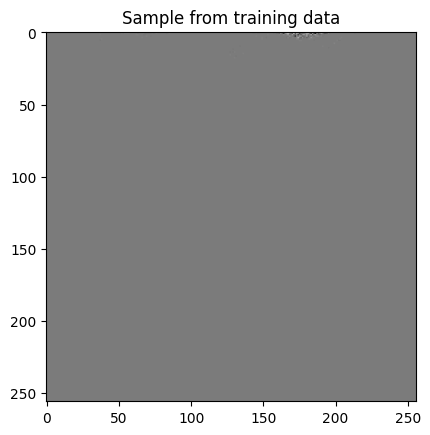

In [13]:
# Visualize sample batch
i = next(iter(no_thorax_sub_train_loader))["image"]
print(i.shape)
plt.imshow(i[0,0], cmap='gray')
plt.title('Sample from training data')
plt.show()


# Training FCN-FFNET


In [28]:
g = reseed()
ENCODER_NAME = None
fcn_ffnet_model = BreastSegmentationModel(
    arch="fcn_ffnet", 
    encoder_name=ENCODER_NAME, 
    loss_function="crossentropy2d",  # Use string instead of instantiating the class
    use_boundary_loss=False,
    img_size=256, 
    in_channels=1, 
    out_classes=1, 
    batch_size=batch_size, 
    len_train_loader=len(train_ds_no_thorax_third_sub)//batch_size
)

es = EarlyStopping(monitor="valid_loss", mode="min", patience=10)

cc_fcn_ffnet_model = ModelCheckpoint(
    monitor="valid_loss",
    save_top_k=1,
    mode="min",
    filename='unet-clahe--mit2-{epoch:02d}-{valid_loss:.2f}',
    dirpath=checkpoints_dir,
    auto_insert_metric_name=False
)

trainer_fcn_ffnet_model = L.Trainer(
    devices = 1,
    accelerator='gpu',
    max_epochs=1000,
    callbacks=[es, cc_fcn_ffnet_model],
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    deterministic=True
)


Seed set to 200


Using random seed 200...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [29]:
trainer_fcn_ffnet_model.fit(
    fcn_ffnet_model,
    train_dataloaders=no_thorax_sub_train_loader,
    val_dataloaders=no_thorax_sub_val_loader
)


c:\Users\pabli\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:701: Checkpoint directory C:\Users\pabli\Desktop\venus\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | FcnnFnet | 17.3 M | train
-------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.049    Total estimated model params size (MB)
103       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\pabli\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\pabli\Desktop\venus\breast_segmentation\metrics\evaluation.py:386: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dice_score = torch.tensor(compute_dice_score_single(y_true_flat, y_pred_flat, class_id, exclude_empty)).float()
c:\Users\pabli\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the val

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [32]:
fcn_ffnet_model = BreastSegmentationModel.load_from_checkpoint(
    cc_fcn_ffnet_model.best_model_path,
    t_loss="crossentropy2d" ,
    boundaryloss=False
)
test_metrics = trainer_fcn_ffnet_model.test(
    fcn_ffnet_model, 
    dataloaders=no_thorax_sub_test_loader, 
    verbose=False
)
pp.pprint(test_metrics[0])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\pabli\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

{   'test_acc_per_dataset_background': 0.0,
    'test_acc_per_dataset_mass': 2.3241394956130534e-05,
    'test_acc_per_image_background': 0.0,
    'test_acc_per_image_mass': 2.3241396775119938e-05,
    'test_accuracy': 2.3679915102547966e-05,
    'test_dice_per_dataset_background': 0.0,
    'test_dice_per_dataset_background_no_empty': 0.0,
    'test_dice_per_dataset_mass': 4.647306923288852e-05,
    'test_dice_per_dataset_mass_no_empty': 4.647306923288852e-05,
    'test_dice_per_image_background': 0.0,
    'test_dice_per_image_background_no_empty': 0.0,
    'test_dice_per_image_mass': 4.640757470042445e-05,
    'test_dice_per_image_mass_no_empty': 4.640757470042445e-05,
    'test_iou_per_dataset_background': 0.0,
    'test_iou_per_dataset_background_no_empty': 0.0,
    'test_iou_per_dataset_mass': 2.3241394956130534e-05,
    'test_iou_per_dataset_mass_no_empty': 2.3241394956130534e-05,
    'test_iou_per_image_background': 0.0,
    'test_iou_per_image_background_no_empty': 0.0,
    'tes

# Training Swin-UNETR


In [ ]:
g = reseed()
ENCODER_NAME = None
swin_unetr_model = BreastSegmentationModel(
    arch="swin_unetr", 
    encoder_name=ENCODER_NAME, 
    loss_function="crossentropy2d",  # Use string instead of instantiating the class
    use_boundary_loss=False,
    img_size=256, 
    in_channels=1, 
    out_classes=1, 
    batch_size=batch_size, 
    len_train_loader=len(train_ds_no_thorax_third_sub)//batch_size
)

es_swin = EarlyStopping(monitor="valid_loss", mode="min", patience=10)

cc_swin_unetr_model = ModelCheckpoint(
    monitor="valid_loss",
    save_top_k=1,
    mode="min",
    filename='swin-unetr-{epoch:02d}-{valid_loss:.2f}',
    dirpath=checkpoints_dir,
    auto_insert_metric_name=False
)


trainer_swin_unetr_model = L.Trainer(
    devices=1,
    accelerator='gpu',
    max_epochs=1000,
    callbacks=[es_swin, cc_swin_unetr_model],
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    deterministic=True
)


In [ ]:
trainer_swin_unetr_model.fit(
    swin_unetr_model,
    train_dataloaders=no_thorax_sub_train_loader,
    val_dataloaders=no_thorax_sub_val_loader
)


In [ ]:
swin_unetr_model = BreastSegmentationModel.load_from_checkpoint(
    cc_swin_unetr_model.best_model_path,
    t_loss="crossentropy2d", 
    boundaryloss=False
)
test_metrics_swin = trainer_swin_unetr_model.test(
    swin_unetr_model, 
    dataloaders=no_thorax_sub_test_loader, 
    verbose=False
)
pp.pprint(test_metrics_swin[0])


# Training Unet++


In [ ]:
g = reseed()
ENCODER_NAME = None
unetplusplus_model = BreastSegmentationModel(
    arch="unetplusplus", 
    encoder_name=ENCODER_NAME, 
    loss_function="crossentropy2d",  # Use string instead of instantiating the class
    use_boundary_loss=False,
    img_size=256, 
    in_channels=1, 
    out_classes=1, 
    batch_size=batch_size, 
    len_train_loader=len(train_ds_no_thorax_third_sub)//batch_size
)

es_unetpp = EarlyStopping(monitor="valid_loss", mode="min", patience=10)

cc_unetplusplus_model = ModelCheckpoint(
    monitor="valid_loss",
    save_top_k=1,
    mode="min",
    filename='unetplusplus-{epoch:02d}-{valid_loss:.2f}',
    dirpath=checkpoints_dir,
    auto_insert_metric_name=False
)


trainer_unetplusplus_model = L.Trainer(
    devices=1,
    accelerator='gpu',
    max_epochs=1000,
    callbacks=[es_unetpp, cc_unetplusplus_model],
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    deterministic=True
)


In [ ]:
trainer_unetplusplus_model.fit(
    unetplusplus_model,
    train_dataloaders=no_thorax_sub_train_loader,
    val_dataloaders=no_thorax_sub_val_loader
)


In [ ]:
unetplusplus_model = BreastSegmentationModel.load_from_checkpoint(
    cc_unetplusplus_model.best_model_path,
    t_loss="unetplusplus_loss", 
    boundaryloss=False
)
test_metrics_unetpp = trainer_unetplusplus_model.test(
    unetplusplus_model, 
    dataloaders=no_thorax_sub_test_loader, 
    verbose=False
)
pp.pprint(test_metrics_unetpp[0])


# Training SegNet


In [ ]:
g = reseed()
ENCODER_NAME = None
segnet_model = BreastSegmentationModel(
    arch="segnet", 
    encoder_name=ENCODER_NAME, 
    loss_function="crossentropy2d",  # Use string instead of instantiating the class
    use_boundary_loss=False,
    img_size=256, 
    in_channels=1, 
    out_classes=1, 
    batch_size=batch_size, 
    len_train_loader=len(train_ds_no_thorax_third_sub)//batch_size
)

es_segnet = EarlyStopping(monitor="valid_loss", mode="min", patience=10)

cc_segnet_model = ModelCheckpoint(
    monitor="valid_loss",
    save_top_k=1,
    mode="min",
    filename='segnet-{epoch:02d}-{valid_loss:.2f}',
    dirpath=checkpoints_dir,
    auto_insert_metric_name=False
)


trainer_segnet_model = L.Trainer(
    devices=1,
    accelerator='gpu',
    max_epochs=1000,
    callbacks=[es_segnet, cc_segnet_model],
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    deterministic=True
)


In [ ]:
trainer_segnet_model.fit(
    segnet_model,
    train_dataloaders=no_thorax_sub_train_loader,
    val_dataloaders=no_thorax_sub_val_loader
)


In [ ]:
segnet_model = BreastSegmentationModel.load_from_checkpoint(
    cc_segnet_model.best_model_path,
    t_loss="crossentropy2d", 
    boundaryloss=False
)
test_metrics_segnet = trainer_segnet_model.test(
    segnet_model, 
    dataloaders=no_thorax_sub_test_loader, 
    verbose=False
)
pp.pprint(test_metrics_segnet[0])


# Training Skinny


In [ ]:
skinny_loss = "dice_ce"
skinny_model = BreastSegmentationModel(
    arch="skinny",
    encoder_name=None,
    loss_function=skinny_loss,  # Use string for DiceCELoss
    loss_kwargs={"sigmoid": True, "lambda_dice": 0.5, "lambda_ce": 0.5},
    use_boundary_loss=False,
    img_size=256,
    in_channels=1,
    out_classes=1,
    batch_size=batch_size,
    len_train_loader=len(train_ds_no_thorax_third_sub)//batch_size
)

# Early stopping for SkinnyNet
es_skinny = EarlyStopping(monitor="valid_loss", mode="min", patience=10)

# Model checkpoint for SkinnyNet
cc_skinny_model = ModelCheckpoint(
    monitor="valid_loss",
    save_top_k=1,
    mode="min",
    dirpath="./checkpoints/",
    filename="skinny_best",
    auto_insert_metric_name=False
)


In [ ]:
# Trainer for SkinnyNet
trainer_skinny_model = L.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    callbacks=[es_skinny, cc_skinny_model],
    deterministic=True,
    precision=16
)

# Train SkinnyNet
trainer_skinny_model.fit(
    skinny_model,
    train_dataloaders=no_thorax_sub_train_loader,
    val_dataloaders=no_thorax_sub_val_loader
)


In [ ]:
# Load best SkinnyNet model and test
skinny_model = BreastSegmentationModel.load_from_checkpoint(
    cc_skinny_model.best_model_path,
    t_loss=skinny_loss, 
    boundaryloss=False
)
test_metrics_skinny = trainer_skinny_model.test(
    skinny_model, 
    dataloaders=no_thorax_sub_test_loader, 
    verbose=False
)
pp.pprint(test_metrics_skinny[0])


# Training ResNet-UNet


In [ ]:
g = reseed()
ENCODER_NAME = "resnet50"
resnet_model = BreastSegmentationModel(
    arch="UNet", 
    encoder_name=ENCODER_NAME, 
    loss_function="dice",  # Use string for DiceLoss
    loss_kwargs={"sigmoid": True},
    use_boundary_loss=False,
    img_size=256, 
    in_channels=1, 
    out_classes=1, 
    batch_size=batch_size, 
    len_train_loader=len(train_ds_no_thorax_third_sub)//batch_size
)

es_resnet = EarlyStopping(monitor="valid_loss", mode="min", patience=10)

cc_resnet_model = ModelCheckpoint(
    monitor="valid_loss",
    save_top_k=1,
    mode="min",
    filename='resnet-unet-{epoch:02d}-{valid_loss:.2f}',
    dirpath=checkpoints_dir,
    auto_insert_metric_name=False
)


trainer_resnet_model = L.Trainer(
    devices=1,
    accelerator='gpu',
    max_epochs=1000,
    callbacks=[es_resnet, cc_resnet_model],
    log_every_n_steps=10,
    gradient_clip_val=1,
    num_sanity_val_steps=1,
    deterministic=True
)


In [ ]:
trainer_resnet_model.fit(
    resnet_model,
    train_dataloaders=no_thorax_sub_train_loader,
    val_dataloaders=no_thorax_sub_val_loader
)


In [ ]:
resnet_model = BreastSegmentationModel.load_from_checkpoint(
    cc_resnet_model.best_model_path,
    t_loss="dice" 
    boundaryloss=False
)
test_metrics_resnet = trainer_resnet_model.test(
    resnet_model, 
    dataloaders=no_thorax_sub_test_loader, 
    verbose=False
)
pp.pprint(test_metrics_resnet[0])
